In [68]:
#Necessary Imports

import numpy as np
from sklearn.decomposition import PCA, KernelPCA
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
import random
from random import shuffle
import scipy.ndimage
import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv3D, Reshape, BatchNormalization, MaxPooling3D, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam, Nadam, Adadelta, Adagrad, Adamax
from tensorflow.keras import backend as K
#K.set_image_dim_ordering('th')
import np_utils
from tensorflow.keras.utils import plot_model
#from keract import get_activations, display_activations
from tensorflow import one_hot as to_categorical


from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io as sci
import time
from sklearn import random_projection as rp
#from skimage.filters import gabor, gaussian
import scipy
import spectral
import time
import math
import pydot
import graphviz

In [69]:
#Specify Window size, Train-Test-Validation split

windowSize = 11
testRatio = 0.9
valRatio = 0.1

In [70]:
#Function to load Dataset

def loadIndianPinesData():
    data = sio.loadmat(r'C:/Users/bishw/OneDrive/Desktop/Indian_pines_corrected.mat')['indian_pines_corrected']
    labels = sio.loadmat(r'C:/Users/bishw/OneDrive/Desktop/Indian_pines_gt.mat')['indian_pines_gt']
    return data, labels

In [71]:
X, y = loadIndianPinesData()
print ("Shape of X : "+str(X.shape))
print ("Shape of y : "+str(y.shape))

#For plotting accuracy plots
y_full = y

Shape of X : (145, 145, 200)
Shape of y : (145, 145)


In [72]:
#Function to normalise dataset

def standartizeData(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    scaler = preprocessing.StandardScaler()  
    newX = scaler.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
    return newX, scaler

In [73]:
X, scaler = standartizeData(X)
print ("Shape of X : "+str(X.shape))

Shape of X : (145, 145, 200)


C:\Users\bishw\Anaconda3\envs\py35\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bishw\Anaconda3\envs\py35\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [74]:
#Function to apply PCA onto the dataset for dimensionality reduction

def applyPCA(X, numComponents=50):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [75]:
X, pca = applyPCA(X)

print ("Shape of X : "+str(X.shape))

#For plotting accuracy plots
X_full = X

Shape of X : (145, 145, 50)


In [76]:
#Function to pad input windows with 0's if necessary for convolution

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

#Function to create windows for input data points

def createPatches(X, y, windowSize=7, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [77]:
X, y = createPatches(X, y, windowSize=windowSize)
print ("Shape of X : "+str(X.shape))
print ("Shape of y : "+str(y.shape))

Shape of X : (10249, 11, 11, 50)
Shape of y : (10249,)


In [78]:
#Function to split the dataset into training, testing and validation samples

def splitTrainTestSet(X, y, testRatio=0.9):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=345, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=testRatio/(testRatio + valRatio), random_state=345, stratify=y_test)
    return X_train, X_test, X_val, y_train, y_test, y_val

In [79]:
X_train, X_test,X_val, y_train, y_test, y_val = splitTrainTestSet(X, y, testRatio)
print ("Shape of X_train : "+str(X_train.shape))
print ("Shape of X_test : "+str(X_test.shape))
print ("Shape of X_val : "+str(X_val.shape))
print ("Shape of y_train : "+str(y_train.shape))
print ("Shape of y_test : "+str(y_test.shape))
print ("Shape of y_val : "+str(y_val.shape))

Shape of X_train : (1024, 11, 11, 50)
Shape of X_test : (8303, 11, 11, 50)
Shape of X_val : (922, 11, 11, 50)
Shape of y_train : (1024,)
Shape of y_test : (8303,)
Shape of y_val : (922,)


In [80]:
#Checking if the dataset has a class imbalance problem

count = y_train
import collections
counter=collections.Counter(count)
print (counter)

Counter({10.0: 245, 1.0: 143, 13.0: 126, 9.0: 97, 2.0: 83, 5.0: 73, 11.0: 59, 4.0: 48, 7.0: 48, 14.0: 39, 3.0: 24, 12.0: 20, 15.0: 9, 0.0: 5, 6.0: 3, 8.0: 2})


In [81]:
#Function definition to oversample weaker classes in the dataset

def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY

In [82]:
X_train,  y_train = oversampleWeakClasses(X_train, y_train)
print ("Shape of X_train : "+str(X_train.shape))
print ("Shape of X_test : "+str(X_test.shape))
print ("Shape of X_val : "+str(X_val.shape))
print ("Shape of y_train : "+str(y_train.shape))
print ("Shape of y_test : "+str(y_test.shape))
print ("Shape of y_val : "+str(y_val.shape))

Shape of X_train : (3950, 11, 11, 50)
Shape of X_test : (8303, 11, 11, 50)
Shape of X_val : (922, 11, 11, 50)
Shape of y_train : (3950,)
Shape of y_test : (8303,)
Shape of y_val : (922,)


In [83]:
#It is now visible that the all the classes in the dataset have about the same number of data points

count = y_train
import collections
counter=collections.Counter(count)
print (counter)

Counter({9.0: 291, 1.0: 286, 13.0: 252, 2.0: 249, 6.0: 246, 0.0: 245, 10.0: 245, 8.0: 244, 15.0: 243, 3.0: 240, 4.0: 240, 7.0: 240, 12.0: 240, 11.0: 236, 14.0: 234, 5.0: 219})


In [84]:
#Function defintion to augment data samples in the dataset

def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),
                                                               reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    
    
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    
    return X_train

In [85]:
X_train = AugmentData(X_train)
print ("Shape of X_train : "+str(X_train.shape))
print ("Shape of X_test : "+str(X_test.shape))
print ("Shape of X_val : "+str(X_val.shape))
print ("Shape of y_train : "+str(y_train.shape))
print ("Shape of y_test : "+str(y_test.shape))
print ("Shape of y_val : "+str(y_val.shape))

Shape of X_train : (3950, 11, 11, 50)
Shape of X_test : (8303, 11, 11, 50)
Shape of X_val : (922, 11, 11, 50)
Shape of y_train : (3950,)
Shape of y_test : (8303,)
Shape of y_val : (922,)


In [86]:
X_train_RNN = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)
X_test_RNN = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3], 1)
X_val_RNN = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], X_val.shape[3], 1)

print ("Shape of X_train_RNN : "+str(X_train_RNN.shape))
print ("Shape of X_test_RNN : "+str(X_test_RNN.shape))
print ("Shape of X_val_RNN : "+str(X_val_RNN.shape))

Shape of X_train_RNN : (3950, 11, 11, 50, 1)
Shape of X_test_RNN : (8303, 11, 11, 50, 1)
Shape of X_val_RNN : (922, 11, 11, 50, 1)


In [87]:
X_train_RES = X_train
X_test_RES = X_test
X_val_RES = X_val

print ("Shape of X_train_RES : "+str(X_train_RES.shape))
print ("Shape of X_test_RES : "+str(X_test_RES.shape))
print ("Shape of X_val_RES : "+str(X_val_RES.shape))

Shape of X_train_RES : (3950, 11, 11, 50)
Shape of X_test_RES : (8303, 11, 11, 50)
Shape of X_val_RES : (922, 11, 11, 50)


In [88]:
#Converting the truth labels to categorical vectors for the training process

y_train = tf.cast(y_train, tf.int32)
y_test = tf.cast(y_test, tf.int32)
y_val = tf.cast(y_val, tf.int32)

y_train = to_categorical(indices = y_train, depth = 16)
y_test = to_categorical(indices = y_test, depth = 16)
y_val = to_categorical(indices = y_val, depth = 16)

y_train = y_train.numpy()
y_test = y_test.numpy()
y_val = y_val.numpy()

print ("Shape of X_train_RNN : "+str(X_train_RNN.shape))
print ("Shape of X_test_RNN : "+str(X_test_RNN.shape))
print ("Shape of X_val_RNN : "+str(X_val_RNN.shape))

print ("Shape of X_train_RES : "+str(X_train_RES.shape))
print ("Shape of X_test_RES : "+str(X_test_RES.shape))
print ("Shape of X_val_RES : "+str(X_val_RES.shape))

print ("Shape of y_train : "+str(y_train.shape))
print ("Shape of y_test : "+str(y_test.shape))
print ("Shape of y_val : "+str(y_val.shape))

Shape of X_train_RNN : (3950, 11, 11, 50, 1)
Shape of X_test_RNN : (8303, 11, 11, 50, 1)
Shape of X_val_RNN : (922, 11, 11, 50, 1)
Shape of X_train_RES : (3950, 11, 11, 50)
Shape of X_test_RES : (8303, 11, 11, 50)
Shape of X_val_RES : (922, 11, 11, 50)
Shape of y_train : (3950, 16)
Shape of y_test : (8303, 16)
Shape of y_val : (922, 16)


In [89]:
input_RNN_shape = X_train_RNN[0].shape
input_RES_shape = X_train_RES[0].shape

inputRNN = Input(shape= input_RNN_shape)
x = Conv3D(filters=16, kernel_size=(3,3,32), data_format='channels_last')(inputRNN)
x = AveragePooling3D(pool_size=(2,2,2), data_format='channels_last')(x)
x = Conv3D(filters=32, kernel_size=(3,3,8), data_format='channels_last')(x)
x = Flatten()(x)
x = Reshape((x.shape[1],1))(x)
y = x
x = Bidirectional(LSTM(1, return_sequences = True), merge_mode='mul')(x)
x = Bidirectional(LSTM(1, return_sequences = True), merge_mode='mul')(x)
x = Flatten()(x)
x = Activation(activation='softmax')(x)
x = Reshape((x.shape[1],1))(x)
x = Multiply()([y, x])
x = Add()([y, x])
x = Flatten()(x)
x = Dense(units = 100, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(rate = 0.2)(x)
x = Dense(units = 50, activation='relu', kernel_regularizer='l2')(x)
#x = Dense(units= 16, activation='softmax')(x)
modelRNN = Model(inputs=inputRNN, outputs=x)

#######################################################################################################################

inputRES = Input(shape= input_RES_shape)
y = inputRES
y = Reshape((windowSize,windowSize,50,1))(y)
y = Conv3D(filters=1, kernel_size=(1,1,25),activation='relu', data_format='channels_last')(y)
y = Conv3D(filters=1, kernel_size=(1,1,26),activation='relu', data_format='channels_last')(y)
y = Flatten()(y)
y = Activation(activation='softmax')(y)
y = Reshape((windowSize,windowSize,1))(y)
#y = tf.keras.backend.repeat_elements(y, X_test_RES.shape[3], axis = 3)
#y = repeat(y, repeats=X_test_RES.shape[3], axis = -1 )
y = tf.tile(input=y, multiples=[1,1,1,X_test_RES.shape[3]])
y = multiply([y, inputRES])
y = Add()([y, inputRES])

#y = Flatten()(y)
#y = Dense(units=16, activation='softmax')(y)

#First layer of ResNet
skip1 = y
skip1 = Conv2D(filters = 32, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_last')(skip1)
skip1 = BatchNormalization()(skip1)
skip1 = Activation(activation='relu')(skip1)
skip1 = Conv2D(filters = 64, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_last')(skip1)
skip1 = BatchNormalization()(skip1)
y = Conv2D(filters = 64, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_last')(y)
y = Add()([y, skip1])
y = Activation(activation='relu')(y)
y = AveragePooling2D(pool_size=(2,2), data_format='channels_last')(y)

#Second layer of ResNet
skip2 = y
skip2 = Conv2D(filters = 32, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_last')(skip2)
skip2 = BatchNormalization()(skip2)
skip2 = Activation(activation='relu')(skip2)
skip2 = Conv2D(filters = 64, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_last')(skip2)
skip2 = BatchNormalization()(skip2)
y = Conv2D(filters = 64, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_last')(y)
y = Add()([y, skip2])
y = Activation(activation='relu')(y)
#extra addition
#y = AveragePooling2D(pool_size=(2,2), data_format='channels_last')(y)

#Third layer of ResNet
skip3 = y
skip3 = Conv2D(filters = 32, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_last')(skip3)
skip3 = BatchNormalization()(skip3)
skip3 = Activation(activation='relu')(skip3)
skip3 = Conv2D(filters = 64, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_last')(skip3)
skip3 = BatchNormalization()(skip3)
y = Conv2D(filters = 64, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_last')(y)
y = Add()([y, skip3])
y = Activation(activation='relu')(y)
y = AveragePooling2D(pool_size=(2,2), data_format='channels_last')(y)

#Dense Layers
y = Flatten()(y)
y = Dense(units = 100, activation='relu', kernel_regularizer='l2')(y)
y = Dropout(rate = 0.2)(y)
y = Dense(units= 50, activation='relu', kernel_regularizer='l2')(y)
#y = Dense(units= 16, activation='softmax')(y)

modelRES = Model(inputs=inputRES, outputs=y)

#############################################################################################################################

#Bringing the output of both the models together to final dense layers
z = add([modelRNN.output, modelRES.output])
z = Dense(units = 25, activation='relu', kernel_regularizer='l2')(z)
z = Dropout(rate = 0.2)(z)
z = Dense(units= y_train.shape[1], activation='softmax')(z)


model = Model(inputs=[modelRNN.input, modelRES.input], outputs=z)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 11, 11, 50)] 0                                            
__________________________________________________________________________________________________
reshape_10 (Reshape)            (None, 11, 11, 50, 1 0           input_6[0][0]                    
__________________________________________________________________________________________________
conv3d_10 (Conv3D)              (None, 11, 11, 26, 1 26          reshape_10[0][0]                 
__________________________________________________________________________________________________
conv3d_11 (Conv3D)              (None, 11, 11, 1, 1) 27          conv3d_10[0][0]                  
____________________________________________________________________________________________

In [90]:
adam = Adam(lr=0.0001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [91]:
start = time.time()

In [92]:
history = model.fit(x=[X_train_RNN, X_train_RES], y=y_train, epochs=100, batch_size=32, validation_data=([X_val_RNN, X_val_RES], y_val))

Train on 3950 samples, validate on 922 samples
Epoch 1/100
3950/3950 [==============================] - 41s 10ms/sample - loss: 6.7697 - accuracy: 0.2210 - val_loss: 6.5627 - val_accuracy: 0.2885
Epoch 2/100
3950/3950 [==============================] - 35s 9ms/sample - loss: 5.4406 - accuracy: 0.5268 - val_loss: 5.4626 - val_accuracy: 0.4490
Epoch 3/100
3950/3950 [==============================] - 32s 8ms/sample - loss: 4.4833 - accuracy: 0.7005 - val_loss: 4.4140 - val_accuracy: 0.7007
Epoch 4/100
3950/3950 [==============================] - 35s 9ms/sample - loss: 3.8633 - accuracy: 0.7975 - val_loss: 3.7484 - val_accuracy: 0.7744
Epoch 5/100
3950/3950 [==============================] - 33s 8ms/sample - loss: 3.4326 - accuracy: 0.8344 - val_loss: 3.2908 - val_accuracy: 0.8590
Epoch 6/100
3950/3950 [==============================] - 32s 8ms/sample - loss: 3.0748 - accuracy: 0.8927 - val_loss: 2.9520 - val_accuracy: 0.9197
Epoch 7/100
3950/3950 [==============================] - 35s 9ms

Epoch 56/100
3950/3950 [==============================] - 32s 8ms/sample - loss: 0.1998 - accuracy: 0.9957 - val_loss: 0.2059 - val_accuracy: 0.9924
Epoch 57/100
3950/3950 [==============================] - 34s 9ms/sample - loss: 0.1932 - accuracy: 0.9965 - val_loss: 0.1903 - val_accuracy: 0.9957
Epoch 58/100
3950/3950 [==============================] - 34s 9ms/sample - loss: 0.1877 - accuracy: 0.9972 - val_loss: 0.1918 - val_accuracy: 0.9967
Epoch 59/100
3950/3950 [==============================] - 32s 8ms/sample - loss: 0.1889 - accuracy: 0.9939 - val_loss: 0.1849 - val_accuracy: 0.9946
Epoch 60/100
3950/3950 [==============================] - 33s 8ms/sample - loss: 0.1782 - accuracy: 0.9954 - val_loss: 0.1917 - val_accuracy: 0.9946
Epoch 61/100
3950/3950 [==============================] - 34s 9ms/sample - loss: 0.1757 - accuracy: 0.9962 - val_loss: 0.1904 - val_accuracy: 0.9881
Epoch 62/100
3950/3950 [==============================] - 35s 9ms/sample - loss: 0.1741 - accuracy: 0.9952

In [93]:
#Evaluating the model's generalisation capability by testing it with the test-dataset samples

score = model.evaluate(x = [X_test_RNN, X_test_RES], y=y_test, batch_size=32)
Test_Loss =  score[0]
Test_accuracy = score[1]*100
print ("Test Accuracy : "+str(Test_accuracy))
print ("Test Loss : "+str(Test_Loss))

8303/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test Accuracy : 98.49451780319214
Test Loss : 0.15058189582411213


In [94]:
end = time.time()
total = (end-start)/60
print ("Total time : "+str(total)+" minutes")

Total time : 56.60677974621455 minutes


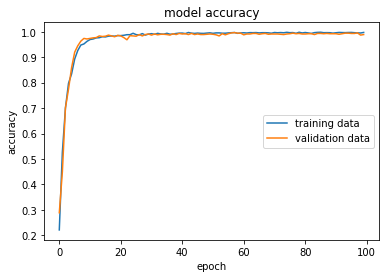

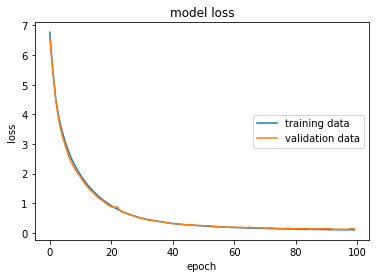

In [95]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='center right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='center right')
plt.show()

In [96]:
#Function definition to plot the accuracy maps

def plot_accuracy_map (X, y):
    Xshape = X
    X, y = createPatches(X, y, windowSize=windowSize, removeZeroLabels=False)
    X_RNN = X.reshape(X.shape[0], X.shape[1], X.shape[2], X.shape[3], 1)
    X_RES = X
    prediction = model.predict([X_RNN, X_RES])
    prediction = np.argmax(prediction, axis = 1)
    
    for i in range(0, len(y)):
        if (y[i] == 0):
            y[i] = 0
        elif (y[i] == 16):
            y[i] = 17
        else :
            y[i] = prediction[i]+1
            
    y = y.reshape((Xshape.shape[0], Xshape.shape[1]))
    predict_image = spectral.imshow(classes = y.astype(int),figsize =(5,5))

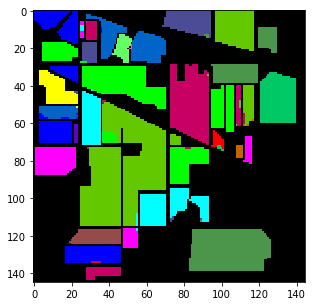

In [97]:
plot_accuracy_map(X_full, y_full)

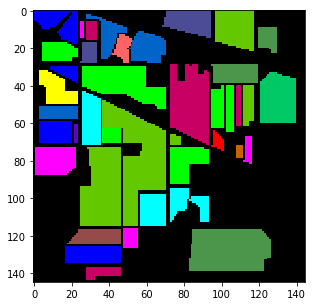

In [98]:
predict_image = spectral.imshow(classes = y_full.astype(int),figsize =(5,5))

In [99]:
#Function definition to save reports onto a file

def reports (X_test_RNN, X_test_RES, y_test):
    prediction = model.predict([X_test_RNN, X_test_RES])
    y_pred = np.argmax(prediction, axis=1)
    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
               ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
               'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
               'Stone-Steel-Towers']

    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names, digits=3)
    #confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate([X_test_RNN, X_test_RES], y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    cohen = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    
    return classification, confusion, Test_Loss, Test_accuracy, cohen, oa


classification, confusion, Test_loss, Test_accuracy, cohen, oa = reports(X_test_RNN, X_test_RES, y_test)
classification = str(classification)
#confusion = str(confusion)
file_name = 'Spatial_Spectral_Attention---' + "WindowSize" + str(windowSize) + '---test_size(%)' + str(testRatio) +'.txt'
with open(file_name, 'w') as x_file:
    #x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('{} Kappa score (%)'.format(cohen*100))
    x_file.write('\n')
    x_file.write('{} Overall Accuracy (%)'.format(oa*100))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    #x_file.write('{}'.format(confusion))

8303/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================